In [1]:
import collections
from datetime import datetime
import os
import random

import keras
from keras import layers, models, optimizers
from keras.applications import VGG16
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFilter
from PIL import Image
from scipy import ndimage, signal
from sklearn.metrics import confusion_matrix, accuracy_score
import tensorflow as tf


# The Problem

The problem is described in detail [here](https://www.aicrowd.com/challenges/ai-blitz-6/problems/chess-pieces). Given the image of a chess board, predict the side (black or white) that has fewer pieces.

# Non-ML Solutions

## First Approach: Intensity Thresholding

### Step 1: Convert RGB to grayscale numpy array

In [2]:
def show_image(image_id=None, what='train'):
    """Show a random or requested image."""
    if image_id is None:
        all_files = os.listdir(what)
        img_file = random.sample(all_files, 1)[0]
        image_id, _ = os.path.splitext(img_file)
    
    label_df = pd.read_csv(f'{what}.csv')
    img = PIL.Image.open(os.path.join(os.getcwd(), what, f'{image_id}.jpg'))
    img = img.resize((256, 256))
    img_np = np.array(img)
    label = label_df[label_df['ImageID'] == int(image_id)].iloc[0, 1]
    return img, img_np, label, image_id

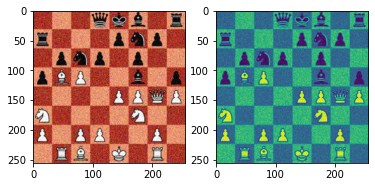

In [ ]:
img, img_np, label, image_id = show_image(0)
imgbw = img.convert(mode='L')
imgbw_np = np.array(imgbw)

plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(imgbw)

### Step 2: Pre-processing

1. Quantize the black and white (grayscale) intensities into three discrete values:
  * 0 for the black pieces
  * 255 for the white pieces
  * 128 for background 

2. Blur the resultant image using a Gaussian blur of predefined radius and quantize again. 
    
The first quantization step creates a grainy texture where the pieces are located thereby deemphasizing the pieces. The blurring step fills in the graininess, but creates pixel intensities other than 0, 255, and 128, which are difficult to use for classification.  Hence, the second quantization step (post-blurring) step quantizes the intensity thresholds again into 0 for the black pieces, 255 for the white pieces, and 128 for background.  

As shown below, the histogram of pixel intensities post-blurring is significantly different from the histogram of the original image.  Hence, different quantization thresholds are used for the first and second steps to discriminate the black and white pieces from the background.  The black and white quantization thresholds for both quantization steps are shown as red vertical lines in the respective histogram plots.  The blur radius was selected empirically to give the best accuracy across files (described below).   

In [ ]:
#Thresholds to go with first quantization.
BLACK_TH1 = 10  # Threshold below which pixels are considered black.
WHITE_TH1 = 246  # Threshold above which pixels are considered white.


def quantize(imgbw_np):
    """
    Quantize the image into three values for black, white, and background.

    Setting three discrete values for each image pixel. One value for each 
    piece color and the third for the background.
    """
    new_img = imgbw_np.copy()
    new_img[imgbw_np < BLACK_TH1] = 0
    new_img[imgbw_np > WHITE_TH1] = 255
    new_img[(imgbw_np >= BLACK_TH1) & (imgbw_np <= WHITE_TH1)] = 128
    
    return new_img

In [ ]:
#Thresholds to go with second quantization.
BLACK_TH2 = 115  # Threshold below which pixels are considered black.
WHITE_TH2 = 135  # Threshold above which pixels are considered white.

def blur_and_quantize(imgbw_np, img=None, img_np=None, rad=2):
    """
    Blur quantized image and then quantize the blurred image again.
    Different pixel intensity thresholds are used for the first and second quantization steps. 
    """
    new_img1 = imgbw_np.copy()
    
    new_img = quantize(imgbw_np)
    img = Image.fromarray(new_img)
    
    # use blurring
    img_blurred = img.filter(ImageFilter.GaussianBlur(radius=rad))
    imgbw_np = np.array(img_blurred)

    
    new_img[imgbw_np < BLACK_TH2] = 0
    new_img[imgbw_np > WHITE_TH2] = 255
    new_img[(imgbw_np >= BLACK_TH2) & (imgbw_np <= WHITE_TH2)] = 128
    
    return new_img

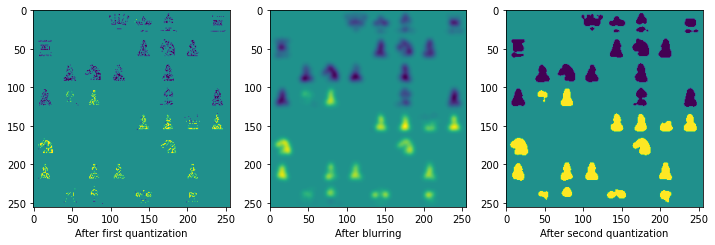

In [ ]:
new_img1 = quantize(imgbw_np)
img = Image.fromarray(new_img1)
new_img_blur = img.filter(ImageFilter.GaussianBlur(radius=3))
new_img2 = blur_and_quantize(imgbw_np, img, img_np)

fig = plt.figure()
fig.set_size_inches(12,6)
plt.subplot(131)
plt.imshow(new_img1)
plt.xlabel('After first quantization')
plt.subplot(132)
plt.imshow(new_img_blur)
plt.xlabel('After blurring')
plt.subplot(133)
plt.imshow(new_img2)
_ = plt.xlabel('After second quantization')

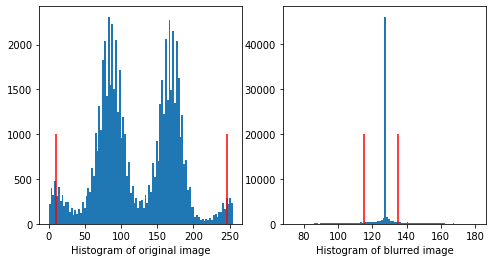

In [ ]:
fig = plt.figure()
fig.set_size_inches(8,4)
plt.subplot(121)
a = plt.hist(imgbw_np.flatten(), bins=100)
plt.vlines(x=BLACK_TH1, ymin=0, ymax=1000, colors='r')
plt.vlines(x=WHITE_TH1, ymin=0, ymax=1000, colors='r')
plt.xlabel('Histogram of original image')
plt.subplot(122)
b = plt.hist(np.array(new_img_blur).flatten(), bins=100)
plt.vlines(x=BLACK_TH2, ymin=0, ymax=20000, colors='r')
plt.vlines(x=WHITE_TH2, ymin=0, ymax=20000, colors='r')
_ = plt.xlabel('Histogram of blurred image')

### Step 3: Segment into blocks and identify centers of the blocks

* Segment the blurred and quantized image on the right above into 64 blocks corresponding to the 64 squares of the chess board (corresponding blocks of the raw BW image are shown below for the first row for reference)
* Identify the center of each block for a predefined width and height in pixels.  The ideal center width is determined empirically as described below.  

In [3]:
# See https://stackoverflow.com/questions/16856788/slice-2d-array-into-smaller-2d-arrays

def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, "{} rows is not evenly divisble by {}".format(h, nrows)
    assert w % ncols == 0, "{} cols is not evenly divisble by {}".format(w, ncols)
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

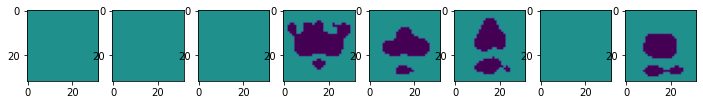

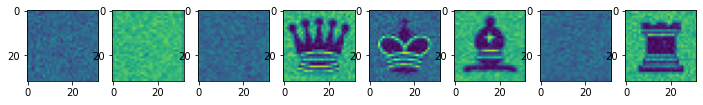

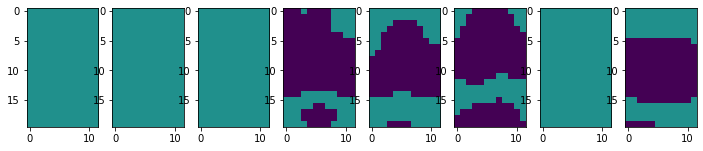

In [ ]:
fig = plt.figure()
fig.set_size_inches((12, 8))
for i in range(8):
    img_block = blockshaped(new_img2, 32, 32)[i]
    plt.subplot(1, 8, i+1)
    plt.imshow(img_block, vmin=0, vmax=255)
    
fig = plt.figure()
fig.set_size_inches((12, 8))
for i in range(8):
    img_block = blockshaped(imgbw_np, 32, 32)[i]
    plt.subplot(1, 8, i+1)
    plt.imshow(img_block, vmin=0, vmax=255)

w = 6
h = w + 4
fig = plt.figure()
fig.set_size_inches((12, 8))
for i in range(8):
    img_block = blockshaped(new_img2, 32, 32)[i]   
    center = img_block[16-h:16+h, 16-w:16+w]
    plt.subplot(1, 8, i+1)
    plt.imshow(center, vmin=0, vmax=255)

### Step 4: Classify each block as white or black


Count pixel intensities in the centers of the blocks, classify each block based on majority in that block, count the total white and black pieces.

* Use a dictionary to count the number of pixels of each intensity 0.0 (for black piece), 255.0 (for white piece), and 128.0 (for background) within each block
* Using a majority pixel counting based heuristic, classify each block as black piece, white piece, or background
* Sum the number of white pieces, the number of black pieces, and background squares

In [ ]:
WHITE_TH3 = 12 
BLACK_TH3 = 15
FRAC = 0.7

def count_black_and_white_pieces(new_img, w=5, center_only=False):
    """
    Classify each block as B piece, W piece, or background
    Count total number of black pieces, white pieces, and background blocks
    """
    white_cnt = 0
    black_cnt = 0
    background_cnt = 0
    
    no_of_blocks = 64
    h = w + 4
    
    for i in range(no_of_blocks):
        
        img_block = blockshaped(new_img, 32, 32)[i]
        
        center = img_block[16-h:16+h, 16-w:16+w]
        if center_only:
            block_dict = collections.Counter(center.flatten())
        else:
            block_dict = collections.Counter(img_block.flatten())
        
        if block_dict[128.0] > np.ceil(FRAC * 4 * h * w):
            background_cnt += 1
        elif (block_dict[255.0] > WHITE_TH3 and 
              block_dict[255.0] > block_dict[0.0] and 
              block_dict[255.0] > np.ceil(block_dict[128.0] / 5)):
            white_cnt += 1
        elif (block_dict[0.0] > BLACK_TH3 and 
              block_dict[0.0] > block_dict[255.0] and 
              block_dict[0.0] > np.ceil(block_dict[128.0] / 5)):
            black_cnt += 1
        else:
            background_cnt += 1
            
    return white_cnt, black_cnt, background_cnt

Predicted White Piece Count =  16
Predicted Black Piece Count =  15
Predicted Background Count =  33


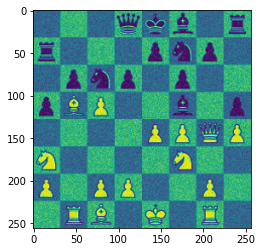

In [ ]:
white_cnt, black_cnt, background_cnt = count_black_and_white_pieces(new_img2, w, center_only=True)

plt.imshow(imgbw_np)

print('Predicted White Piece Count = ', white_cnt)
print('Predicted Black Piece Count = ', black_cnt)
print('Predicted Background Count = ', background_cnt)

### Step 5: Output the piece color which has the lower number of pieces on the board

In [ ]:
def count_majority(im_id=None, w=5, rad=3):
    """
    Count majority pieces (black or white) given an image id
    """
    
    img, img_np, label, image_id = show_image(im_id)
    imgbw = img.convert(mode='L')
    imgbw_np = np.array(imgbw)
    
    new_img1 = blur_and_quantize(imgbw_np, img, img_np, rad)
    
    white_cnt, black_cnt, background_cnt = count_black_and_white_pieces(new_img1, w, center_only=True)
    
    if white_cnt < black_cnt:
        return(label, 'white')
    return(label, 'black')

In [ ]:
true_label, predicted_label = count_majority(im_id=0, w=6)

print('True Label = ', true_label)
print('Predicted Label = ', predicted_label)

True Label =  black
Predicted Label =  black


### Step 6: Repeat over multiple files to generate a confusion matrix and accuracy score

In [ ]:
def confusion_matrix_for_folder(what='train', w=5, rad=3, to_print=True):
    """
    Compares true and predicted labels across multiple images.  
    Provides the accuracy score and confusion matrix across the multiple images.
    
    """
    true_labels = []
    predicted_labels = []
    mislabeled = []
    all_files = [x for x in os.listdir(what) if x.endswith('.jpg')]
    subset = random.sample(all_files, 1000)
    #for file in all_files[:1000]:
    for file in subset:
        image_id, _ = os.path.splitext(file)
        im_id = int(image_id)
        true, predicted = count_majority(im_id, w, rad)
        if true != predicted:
            mislabeled.append(im_id)
        true_labels.append(true)
        predicted_labels.append(predicted)
        
    cm = confusion_matrix(true_labels, predicted_labels, normalize='true')
    if to_print:
        print('Confusion Matrix: ')
        print(cm)
    score = accuracy_score(true_labels, predicted_labels)
    return score #, mislabeled

In [ ]:
accuracy = confusion_matrix_for_folder(what='train', w=6, rad=2)

print('Accuracy Score = ', accuracy)

Confusion Matrix: 
[[1.         0.        ]
 [0.00619835 0.99380165]]
Accuracy Score =  0.997


The ideal center width to use in Step 3 is determined emperically as shown below. The graph below shows the accuracy score as a function of center width. Center width between 2 and 6 gives the best accuracy scores.  

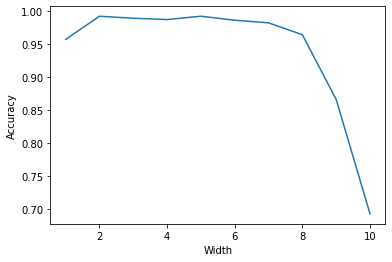

In [ ]:
score = []
for width in range(1, 11):
    accuracy = confusion_matrix_for_folder(what='train', w=width, rad=3, to_print=False)
    score.append(accuracy)
    
plt.plot(range(1, 11), score)
plt.xlabel('Width')
_ = plt.ylabel('Accuracy')

The ideal blur radius to use in Step 2 is determined emperically as shown below. The graph below shows the accuracy score as a function of blur radius. Blur radius of 2 or 3 was selected.  

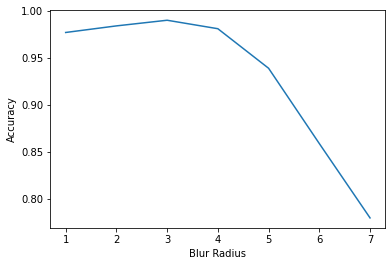

In [ ]:
score = []
for radius in range(1, 8):
    accuracy = confusion_matrix_for_folder(what='train', w=6, rad=radius, to_print=False)
    score.append(accuracy)
    
plt.plot(range(1, 8), score)
plt.xlabel('Blur Radius')
_ = plt.ylabel('Accuracy')

### An example of an image where the above approach fails to classify pieces correctly


In the example shown below, the first quantization steps fails to extract/emphasize all the white pieces adequately, resulting in an inaccurately low white piece count.  This step also causes some of the dark background to leak into the quantized image, resulting in an inaccurately high calculation of black piece count. The histogram of grayscale intensities shows that the black pieces are difficult to disriminate from the black background using the black quantization threshold. The black and white quantization thresholds are shown as red vertical lines.  Separate quantization thresholds were explored for the Red, Green, and Blue histograms (also shown below), but this approach also failed to accurately discriminate the black pieces from the dark squares.    

label =  black
White =  12
Black =  13
Background =  39


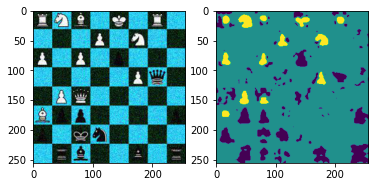

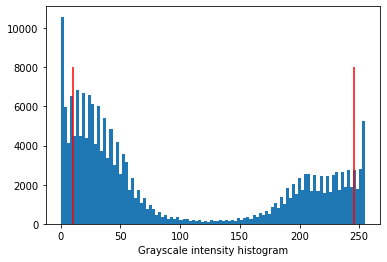

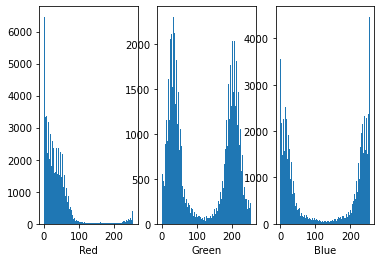

In [ ]:
img, img_np, label, image_id = show_image(35161)
imgbw = img.convert(mode='L')
imgbw_np = np.array(imgbw)
new_img1 = quantize(imgbw_np)
new_img2 = blur_and_quantize(imgbw_np, img, img_np)

plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(new_img2)

fig = plt.figure()
plt.hist(img_np.flatten(), bins=100)
plt.xlabel('Grayscale intensity histogram')
plt.vlines(x=BLACK_TH1, ymin=0, ymax=8000, colors='r')
plt.vlines(x=WHITE_TH1, ymin=0, ymax=8000, colors='r')

fig = plt.figure()
plt.subplot(131)
plt.hist(img_np[:,:,0].flatten(), bins=100)
plt.xlabel('Red')
plt.subplot(132)
plt.hist(img_np[:,:,1].flatten(), bins=100)
plt.xlabel('Green')
plt.subplot(133)
plt.hist(img_np[:,:,2].flatten(), bins=100)
plt.xlabel('Blue')
white_cnt, black_cnt, background_cnt = count_black_and_white_pieces(imgbw_np, new_img2, w=6, center_only=True)
print('label = ', label)
print('White = ', white_cnt)
print('Black = ', black_cnt)
print('Background = ', background_cnt)

## Second Approach: Template matching

In this approach, template matching was used to determine whether a piece was present in a given block.  Then, counts of pixel intensities from the blurred and quantized image of the piece block were used to discriminate black colored pieces from white colored pieces.  

### Step 1: Generate templates

From training image 0, select black and white pawn pieces, each on black (dark) background and white (light) background.  Use these four blocks as templates for subsequent template matching

In [ ]:
def return_templates(to_print=False):
    """
    Return templates for black and white pieces.

    Use image 0 to pick out two black pieces (pawns) and two white pieces 
    (pawns) for template-matching
    """
    img_template, img_np, label, image_id = show_image(0)
    imgbw_template = img_template.convert(mode='L')
    imgbw_np_template = np.array(imgbw_template)
    
    template_b1 = blockshaped(imgbw_np_template, 32, 32)[24]
    template_b2 = blockshaped(imgbw_np_template, 32, 32)[31]
    template_w1 = blockshaped(imgbw_np_template, 32, 32)[48]
    template_w2 = blockshaped(imgbw_np_template, 32, 32)[51]
    
    if to_print:
        plt.imshow(imgbw_np_template)
        
        fig = plt.figure()
        plt.subplot(2,2,1)
        plt.imshow(template_b1)
        plt.subplot(2,2,2)
        plt.imshow(template_b2)
        plt.subplot(2,2,3)
        plt.imshow(template_w1)
        plt.subplot(2,2,4)
        plt.imshow(template_w2)
            
            
    return template_b1, template_b2, template_w1, template_w2


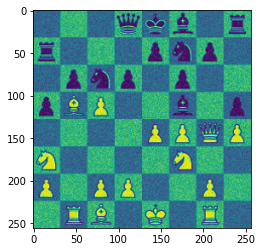

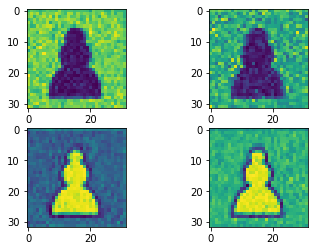

In [ ]:
template_b1, template_b2, template_w1, template_w2 = return_templates(to_print=True)

### Step 2: Identify whether or not a piece is present on a block

Select correlation thresholds heuristically

* Look at the max correlation values for the black and white piece templates (selected in step 1 above) when correlated with a background block and with a piece block
* Select a black correlation threshold for discriminating background from a (black) piece when correlating with the black piece template 
* Similarly select a white correlation threshold for discriminating background from a (white) piece when correlating with the white piece template


Selected correlation thresholds are: black = 200 and white = 180

In [4]:
def norm_corr(block, template):
    """
    Perform normalized 2D correlation.

    Subtract block mean from block and template mean from template before 
    correlating. Divide correlation output by block standard deviation and 
    template standard deviation.
    """
    return signal.correlate2d(block - np.mean(block), template - np.mean(template)) / (np.std(block) * np.std(template))

Consider the image that did not produce accurate results using the first approach above

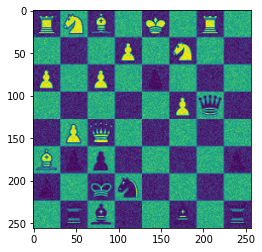

In [ ]:
img, img_np, label, image_id = show_image(35161)
imgbw = img.convert(mode='L')
imgbw_np = np.array(imgbw)
plt.imshow(imgbw_np)

Consider a white piece from the above image, selected at random.  Correlate this white piece with one of the black piece templates and one of the white piece templates.  The correlation score with the white piece template exceeds the white correlation threshold (197.268 > 180), hence this white piece block gets detected as a piece. 

Correlating a white piece with:
Black template:  177.52073483451397
White template:  197.2680620624335


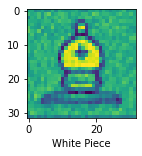

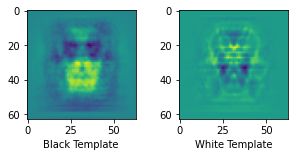

In [ ]:
out1 = norm_corr(blockshaped(imgbw_np, 32, 32)[40], template_b2)
out2 = norm_corr(blockshaped(imgbw_np, 32, 32)[40], template_w2)

fig = plt.figure(figsize=(2, 2))
plt.imshow(blockshaped(imgbw_np, 32, 32)[40])
plt.xlabel('White Piece')
fig = plt.figure(figsize=(5, 2))
plt.subplot(121)
plt.imshow(out1)
plt.xlabel('Black Template')
plt.subplot(122)
plt.imshow(out2)
plt.xlabel('White Template')

print("Correlating a white piece with:")
print("Black template: ", np.max(out1.flatten()))
print("White template: ", np.max(out2.flatten()))



Consider a black piece from the above image, selected at random. Correlate this black piece with one of the black piece templates and one of the white piece templates. The correlation score with the black piece template exceeds the black correlation threshold (504.209 > 200), hence this black piece block gets detected as a piece.

Correlating a black piece with:
Black template:  504.20949012586823
White template:  118.51199896328971


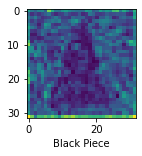

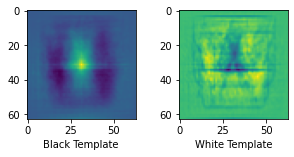

In [ ]:
out3 = norm_corr(blockshaped(imgbw_np, 32, 32)[41], template_b2)
out4 = norm_corr(blockshaped(imgbw_np, 32, 32)[41], template_w2)

fig = plt.figure(figsize=(2, 2))
plt.imshow(blockshaped(imgbw_np, 32, 32)[41])
plt.xlabel('Black Piece')
fig = plt.figure(figsize=(5, 2))
plt.subplot(121)
plt.imshow(out3)
plt.xlabel('Black Template')
plt.subplot(122)
plt.imshow(out4)
plt.xlabel('White Template')

print("Correlating a black piece with:")
print("Black template: ", np.max(out3.flatten()))
print("White template: ", np.max(out4.flatten()))



Now finally consider a background block from the above image, selected at random. Correlate this block with one of the black piece templates and one of the white piece templates. The correlation score with the neither template exceeds the respective correlation thresholds (79.573 < 200 and 158.153 < 180), hence this block gets detected as a background block.

Correlating a background block with:
Black template:  79.57362654619321
White template:  158.15356717614887


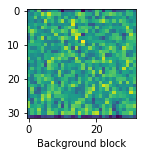

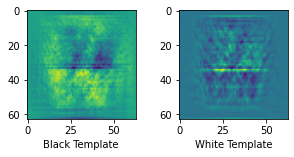

In [ ]:

out5 = norm_corr(blockshaped(imgbw_np, 32, 32)[8], template_b2)
out6 = norm_corr(blockshaped(imgbw_np, 32, 32)[8], template_w2)

fig = plt.figure(figsize=(2, 2))
plt.imshow(blockshaped(imgbw_np, 32, 32)[8])
plt.xlabel('Background block')
fig = plt.figure(figsize=(5, 2))
plt.subplot(121)
plt.imshow(out5)
plt.xlabel('Black Template')
plt.subplot(122)
plt.imshow(out6)
plt.xlabel('White Template')

print("Correlating a background block with:")
print("Black template: ", np.max(out5.flatten()))
print("White template: ", np.max(out6.flatten()))

### Step 3: Classify an identified piece as black or white:

* Use the quantized and blurred image (obtained as in approach 1) of the block that has a piece 
* Count the number of white pixels vs. the number of black pixels in the center of the quantized block (center width is selected empirically as explained for approach 1 above)
* Classify as black or white piece based on a majority counting heuristic.  As shown in the images below, the center of the white rook piece (after blurring and quantizing) has a majority of white pixels and the center of the black bishop piece (after blurring and quantizing) has a majority of black pixels.  

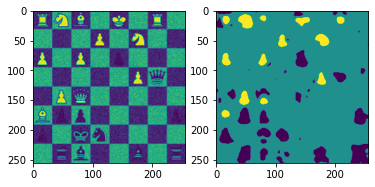

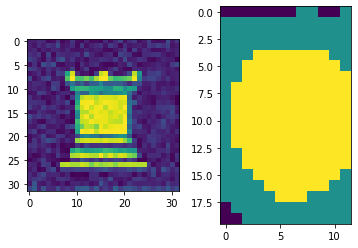

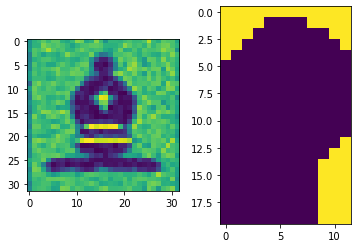

In [ ]:
new_img1 = blur_and_quantize(imgbw_np, img, img_np, rad=3)
w = 6
h = w + 4
    
plt.subplot(121)
plt.imshow(imgbw_np)
plt.subplot(122)
plt.imshow(new_img1)

fig = plt.figure()
plt.subplot(121)
plt.imshow(blockshaped(imgbw_np, 32, 32)[0])
plt.subplot(122)
plt.imshow(blockshaped(new_img1, 32, 32)[0][16-h:16+h, 16-w:16+w])

fig = plt.figure()
plt.subplot(121)
plt.imshow(blockshaped(imgbw_np, 32, 32)[58])
plt.subplot(122)
plt.imshow(blockshaped(new_img1, 32, 32)[58][16-h:16+h, 16-w:16+w])

### Step 4: Count number of white pieces and number of black pieces and output the piece color which has the lower number of pieces on the board

In [ ]:
BL_CORR_TH = 200
WH_CORR_TH = 180

WHITE_TH4 = 9 
BLACK_TH4 = 20

def count_black_and_white_pieces2(imgbw_np, new_img, w=5, center_only=False):
    """
    Classify each block as B piece, W piece, or background
    Count total number of black pieces, white pieces, and background blocks
    """
    white_cnt = 0
    black_cnt = 0
    background_cnt = 0
    
    no_of_blocks = 64

    h = w + 4
    
    
    template_b1, template_b2, template_w1, template_w2 = return_templates(to_print=False)
    for i in range(no_of_blocks):
        img_block_raw = blockshaped(imgbw_np, 32, 32)[i]
        img_block_quantized = blockshaped(new_img, 32, 32)[i]
        
        # First, detect via correlation (template-matching) whether there is a piece or not in a given block
        out1 = norm_corr(img_block_raw, template_b1)
        out2 = norm_corr(img_block_raw, template_b2)
        out3 = norm_corr(img_block_raw, template_w1)
        out4 = norm_corr(img_block_raw, template_w2)
        
        if (np.max(out1.flatten()) < BL_CORR_TH and 
            np.max(out2.flatten()) < BL_CORR_TH and 
            np.max(out3.flatten()) < WH_CORR_TH and 
            np.max(out4.flatten()) < WH_CORR_TH):
            background_cnt += 1  # Background block correlated with none of the four templates will meet the specified thresholds
        
        # Second, if piece is present (if any one of the thresholds above is met), detect using majority counting hueristic whether the piece is black or white
        else:
            if center_only:
                center = img_block_quantized[16-h:16+h, 16-w:16+w]
                block_dict = collections.Counter(center.flatten())
            else:
                block_dict = collections.Counter(img_block_quantized.flatten())
            
            
            if (block_dict[255.0] > WHITE_TH4 or 
                block_dict[255.0] > block_dict[0.0]): 
                white_cnt += 1
                
            elif (block_dict[0.0] > BLACK_TH4 and 
                  block_dict[0.0] > block_dict[255.0]): 
                black_cnt += 1
                
            else:
                background_cnt += 1
                    
            
    return white_cnt, black_cnt, background_cnt

For the image that was inaccurately classified by approach 1, this second gives the correct prediction

Predicted White Piece Count =  13
Predicted Black Piece Count =  12
Predicted Background Count =  39


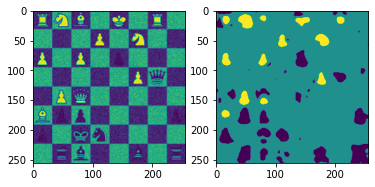

In [ ]:
white_cnt, black_cnt, background_cnt = count_black_and_white_pieces2(imgbw_np, new_img1, w=6, center_only=True)

plt.subplot(121) 
plt.imshow(imgbw_np)
plt.subplot(122)
plt.imshow(new_img1)

print('Predicted White Piece Count = ', white_cnt)
print('Predicted Black Piece Count = ', black_cnt)
print('Predicted Background Count = ', background_cnt)

In [ ]:
def count_majority2(im_id=None, w=5, rad=3):
    """
    Count majority pieces (black or white) given an image id
    """
    img, img_np, label, image_id = show_image(im_id)
    
    imgbw = img.convert(mode='L')
    imgbw_np = np.array(imgbw)
    
    new_img1 = blur_and_quantize(imgbw_np, img, img_np, rad)
    
    white_cnt, black_cnt, background_cnt = count_black_and_white_pieces2(imgbw_np, new_img1, w, center_only=True)
    
    if white_cnt < black_cnt:
        return(label, 'white')
    
    return(label, 'black')

In [ ]:
true_label, predicted_label = count_majority2(im_id=35161, w=5)

print('True Label = ', true_label)
print('Predicted Label = ', predicted_label)

True Label =  black
Predicted Label =  black


### Step 5: Repeat over multiple files and generate a confusion matrix and accuracy score

In [ ]:
def confusion_matrix_for_folder2(what='train', w=5, rad=3, to_print=True):
    """
    Compares true and predicted labels across multiple images.  
    Provides the accuracy score and confusion matrix across the multiple images.
    
    """
    true_labels = []
    predicted_labels = []
    mislabeled = []
    all_files = [x for x in os.listdir(what) if x.endswith('.jpg')]
    subset = random.sample(all_files, 1000)
    for file in subset:
        image_id, _ = os.path.splitext(file)
        im_id = int(image_id)
        true, predicted = count_majority2(im_id, w, rad)
        if true != predicted:
            mislabeled.append(im_id)
        true_labels.append(true)
        predicted_labels.append(predicted)
        
    cm = confusion_matrix(true_labels, predicted_labels, normalize='true')
    if to_print:
        print('Confusion Matrix: ')
        print(cm)
    score = accuracy_score(true_labels, predicted_labels)
    return score, mislabeled

In [ ]:
score, mislabeled = confusion_matrix_for_folder2(what='train', w=6, rad=3, to_print=True)
print('Accuracy = ', score)
print('Mislabeled Files: ', mislabeled)

Confusion Matrix: 
[[1. 0.]
 [0. 1.]]
Accuracy =  1.0
Mislabeled Files:  []


### An example of an image where the above approach fails to classify pieces correctly

This approach misses a white piece

Predicted White Piece Count =  14
Predicted Black Piece Count =  14
Predicted Background Count =  36


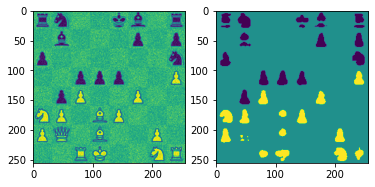

In [ ]:
img, img_np, label, image_id = show_image(35393)
imgbw = img.convert(mode='L')
imgbw_np = np.array(imgbw)
new_img1 = quantize(imgbw_np)
new_img2 = blur_and_quantize(imgbw_np, img, img_np)

plt.subplot(121) 
plt.imshow(imgbw)
plt.subplot(122)
plt.imshow(new_img2)

white_cnt, black_cnt, background_cnt = count_black_and_white_pieces2(imgbw_np, new_img2, w=5, center_only=True)

print('Predicted White Piece Count = ', white_cnt)
print('Predicted Black Piece Count = ', black_cnt)
print('Predicted Background Count = ', background_cnt)

# Using Neural Networks (ML)

## Reference Model: Using RGB input

In [5]:
class DataGen1(keras.utils.Sequence):
    
    def __init__(self, what='train', batch_size=16, image_size=None, convert_to_bw=True):
        self.what = what
        self.batch_size = batch_size
        self.image_size = image_size
        self.convert_to_bw = convert_to_bw
        
        self.all_files = [x for x in os.listdir(self.what) if x.endswith('jpg')]
        random.shuffle(self.all_files)
        
    def __len__(self):    
        return int(np.ceil(len(self.all_files) / self.batch_size))
        
    def __getitem__(self, batch_num):
        x = []
        y = []
        all_files = self.all_files
        batch_size = self.batch_size
        for file in all_files[batch_num * batch_size: (batch_num + 1) * batch_size]:
            image_id, _ = os.path.splitext(file)
            im_id = int(image_id)
            img, img_np, label, image_id = show_image(im_id)
            if self.image_size:
                img = img.resize(self.image_size)
            
            if self.convert_to_bw:
                img = img.convert('L')
                img_np = np.expand_dims(np.array(img) / 255., -1)
            else:
                img_np = np.array(img) / 255.
                    
            x.append(img_np)
            y.append(0.0 if label == 'black' else 1.0)
        return np.array(x), np.array(y)
        
    def on_epoch_end(self):
        random.shuffle(self.all_files)

In [6]:
train_gen = DataGen1('train', batch_size=16, convert_to_bw=False)
val_gen = DataGen1('val', batch_size=16, convert_to_bw=False)

In [7]:
def build_model0():
    inp = keras.Input(shape=(256, 256, 3))
    x = keras.layers.Conv2D(9, (3, 3), activation='relu')(inp)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
    x = keras.layers.Flatten()(x)
    out = keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(1e-3),
        metrics=['accuracy'],
    )
    
    return model

In [8]:
model = build_model0()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 9)       252       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 9)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 16)      1312      
_________________________________________________________________
flatten (Flatten)            (None, 250000)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 250001    
Total params: 251,565
Trainable params: 251,565
Non-trainable params: 0
_______________________________________________________

In [9]:
history = model.fit(train_gen, 
                    validation_data=val_gen, 
                    verbose=0,
                    epochs=500,
                    steps_per_epoch=8,
                    validation_freq=50)

0.9819999933242798

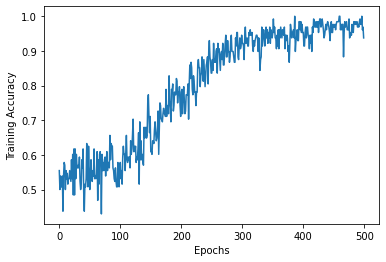

In [10]:
plt.plot(history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')

np.max(history.history['val_accuracy'])

## Other ML architectures 

### Model 1: Using grayscale input, smaller image, but the same architecture as above

For a given number of epochs, the performance for this model is worse than with RGB input

In [11]:
train_gen = DataGen1('train', batch_size=16, image_size=(64, 64))
val_gen = DataGen1('val', batch_size=16, image_size=(64, 64))

In [20]:
def build_model1():
    inp = keras.Input(shape=(64, 64, 1))
    x = keras.layers.Conv2D(9, (3, 3), activation='relu')(inp)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
    x = keras.layers.Flatten()(x)
    out = keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(1e-3),
        metrics=['accuracy'],
    )
    
    return model

In [21]:
model = build_model1()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 62, 62, 9)         90        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 9)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 16)        1312      
_________________________________________________________________
flatten_2 (Flatten)          (None, 13456)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13457     
Total params: 14,859
Trainable params: 14,859
Non-trainable params: 0
_______________________________________________________

In [22]:
history = model.fit(train_gen, 
                    validation_data=val_gen,
                    verbose=0,
                    epochs=1000,
                    steps_per_epoch=8,
                    validation_freq=50)

0.9367499947547913

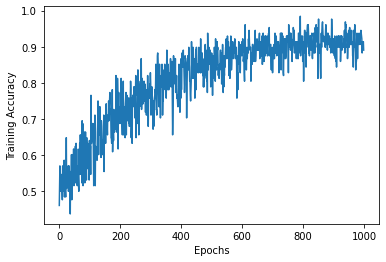

In [23]:
plt.plot(history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')

np.max(history.history['val_accuracy'])

### Model 2: Using two inputs for training: blurred and quantized BW image and labels from the first non-ML approach (intensity-based quantization)

This model was aimed at investigating if the labels from the first non-ML approach above (along with the blurred and quantized images) could be used to train the ML model to improve accuracy above what was obtained using just the first non-ML approach above. However, the validation accuracy did not improve significantly over what was obtained using just the non-ML model.  The weights from the convolutional layer indicate that this layer was used for the prediction task.  The prediction did not rely solely on the labels from the first non-ML approach. 

In [ ]:
WHITE_TH6 = 9
BLACK_TH6 = 11
    
FRAC = 0.7

def vector_black_white_background_pieces(new_img, center_only=False):
    """
    Generate a vector 'y' having 64 elements corresponding to the 64 blocks of the chess board.
    An element of 'y' has value 0.0 if background, +1.0 if white piece, or -1.0 if black piece
    """
    no_of_blocks = 64
    w = 6
    h = w + 4
    x = []
    y = []
    
    for i in range(no_of_blocks):
        
        img_block = blockshaped(new_img, 32, 32)[i]
        #plt.imshow(img_block, cmap='gray')
        x.append(img_block)
        
        if center_only:
            center = img_block[16-w:16+w, 16-h:16+h]
            block_dict = collections.Counter(center.flatten())
        else:
            block_dict = collections.Counter(img_block.flatten())
        #print(block_dict)
        if block_dict[128.0] > np.ceil(FRAC * 4 * h * w):
            y.append(0.0)
        elif (block_dict[255.0] > block_dict[0.0] and 
              block_dict[255.0] > WHITE_TH6 and 
              block_dict[255.0] > np.ceil(block_dict[128.0] / 30)):
            y.append(1.0)
        elif (block_dict[0.0] > block_dict[255.0] and 
              block_dict[0.0] > BLACK_TH6 and 
              block_dict[0.0] > np.ceil(block_dict[128.0] / 30)):
            y.append(-1.0)
        else:
            y.append(0.0)
    
    x = np.array(x)
    x = np.expand_dims(x, -1)
    y = np.array(y)
    return x, y

In [ ]:
class DataGen2(keras.utils.Sequence):
    
    def __init__(self, what='train', batch_size=16):
        self.what = what
        self.batch_size = batch_size
        
        self.all_files = [x for x in os.listdir(self.what) if x.endswith('jpg')]
        random.shuffle(self.all_files)
        
    def __len__(self):    
        return int(np.ceil(len(self.all_files) / self.batch_size))
        
    def __getitem__(self, batch_num):
        x = []
        x1 = []
        y = []
        all_files = self.all_files
        batch_size = self.batch_size
        for file in all_files[batch_num * batch_size: (batch_num + 1) * batch_size]:
            image_id, _ = os.path.splitext(file)
            im_id = int(image_id)
            img, img_np, label, image_id = show_image(im_id, what=self.what)
            img1 = img.convert('L')
            img_quantize = blur_and_quantize(np.array(img1), img)
            _, x_labels = vector_black_white_background_pieces(np.array(img_quantize), center_only=True)
            
            x.append(np.expand_dims(img_quantize / 255., -1))
            
            x1.append(x_labels) 
            y.append(0.0 if label == 'black' else 1.0)
        return (np.array(x), np.array(x1)), np.array(y)
        
    def on_epoch_end(self):
        random.shuffle(self.all_files)

In [ ]:
train_gen = DataGen2('train', batch_size=16)
val_gen = DataGen2('val', batch_size=16)

In [ ]:
def build_model2():
    img_inp = keras.Input(shape=(256, 256, 1), name='img')
    label_inp = keras.Input(shape=(64,), name='labels')
    x = keras.layers.Conv2D(16, (3, 3), activation='relu')(img_inp)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Concatenate()([x, label_inp])
   
    out = keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[img_inp, label_inp], outputs=out)
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(1e-3),
        metrics=['accuracy'],
    )
    
    return model

In [ ]:
model = build_model2()
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 254, 254, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 127, 127, 16) 0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
flatten_11 (Flatten)            (None, 258064)       0           max_pooling2d_8[0][0]            
___________________________________________________________________________________________

In [ ]:
history = model.fit(train_gen, 
                    validation_data=val_gen, 
                    epochs=250,
                    steps_per_epoch=8,
                    verbose=0,
                    validation_freq=50)

0.9557499885559082

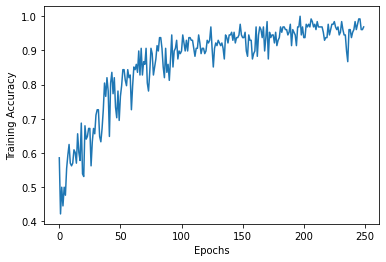

In [ ]:
plt.plot(history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')

np.max(history.history['val_accuracy'])

In [ ]:
train_gen[0][0][1].shape

(16, 64)

In [ ]:
debug_in = train_gen[0][0][0][1:2], train_gen[0][0][1][1:2]
new_model = keras.Model(inputs=model.input, outputs=model.layers[1].output)

debug_in = train_gen[0][0][0][1:2], train_gen[0][0][1][1:2]
output = np.squeeze(new_model.predict(debug_in))

In [ ]:
output.shape

(254, 254, 16)

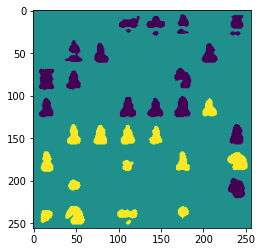

In [ ]:
plt.imshow(debug_in[0][0])

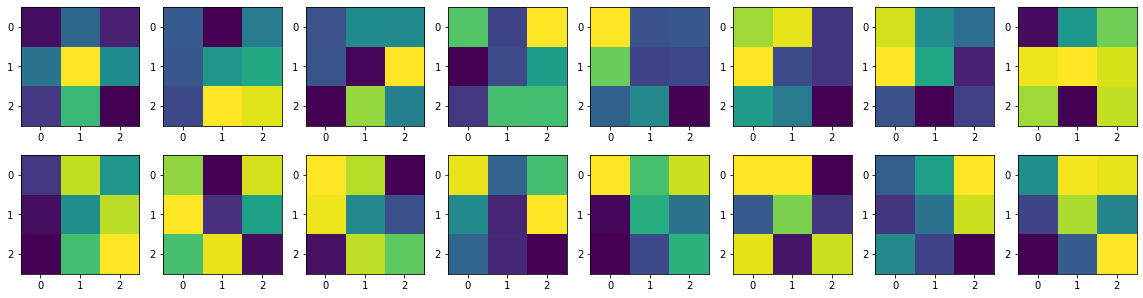

In [ ]:
weights = np.squeeze(model.layers[1].get_weights()[0], -2)
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(20, 5))
axes = axes.flatten()
for idx, ax in zip(range(weights.shape[-1]), axes):
    ax.imshow(np.squeeze(weights[:, :, idx]))

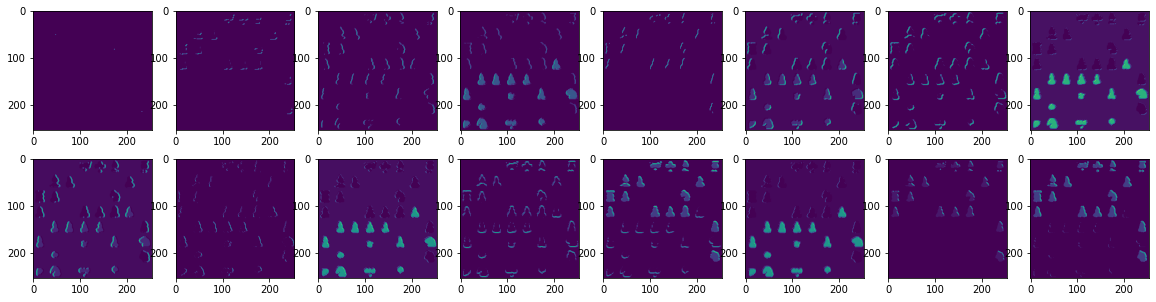

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(20, 5))
axes = axes.flatten()
for idx, ax in zip(range(output.shape[-1]), axes):
    ax.imshow(np.squeeze(output[:, :, idx]))

(254, 254, 16)


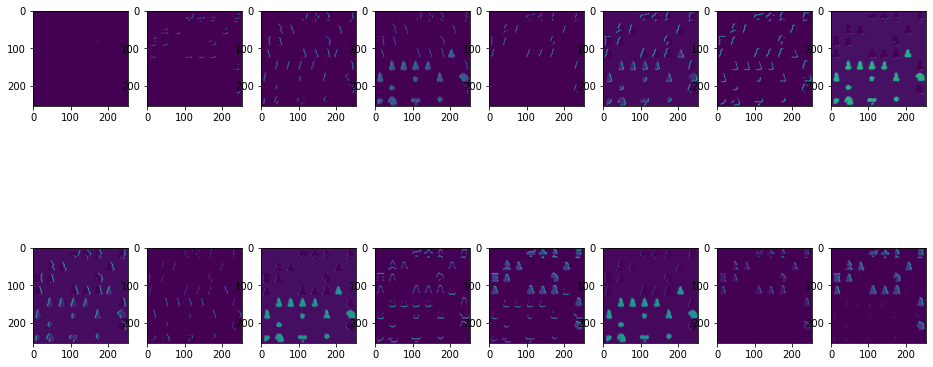

In [ ]:
new_model = keras.Model(inputs=model.input, outputs=model.layers[1].output)
output = np.squeeze(new_model.predict(debug_in))
print(output.shape)

fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(16, 8))
axes = axes.flatten()
for idx, ax in zip(range(output.shape[-1]), axes):
    ax.imshow(np.squeeze(output[:, :, idx]))

### Model 3: Using 64 channels as input, each channel corresponding to a block

This approach did not work well: the average training accuracy was no better than random guessing

In [ ]:
class DataGen3(keras.utils.Sequence):
    
    def __init__(self, what='train', batch_size=16):
        self.what = what
        self.batch_size = batch_size
        
        self.all_files = [x for x in os.listdir(self.what) if x.endswith('jpg')]
        random.shuffle(self.all_files)
        
    def __len__(self):    
        return int(np.ceil(len(self.all_files) / self.batch_size))
        
    def __getitem__(self, batch_num):
        x = []
       
        y = []
        all_files = self.all_files
        batch_size = self.batch_size
        for file in all_files[batch_num * batch_size: (batch_num + 1) * batch_size]:
            image_id, _ = os.path.splitext(file)
            im_id = int(image_id)
            img, img_np, label, image_id = show_image(im_id, what=self.what)
            img = img.convert('L')
                        
            img_block = blockshaped(np.array(img), 32, 32)
            img_block = np.swapaxes(img_block, 0, -1)
    
            x.append(np.array(img_block) / 255.)
             
            y.append(0.0 if label == 'black' else 1.0)
        return np.array(x), np.array(y)
        
    def on_epoch_end(self):
        random.shuffle(self.all_files)

In [ ]:
train_gen = DataGen3('train', batch_size=16)
val_gen = DataGen3('val', batch_size=16)

In [ ]:
def build_model3():
    inp = keras.Input(shape=(32, 32, 64), name='img')
    
    x = keras.layers.Conv2D(32, (3, 3), activation='relu')(inp)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Flatten()(x)
    
    x = keras.layers.Dense(32, activation='relu')(x)
    out = keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(1e-3),
        metrics=['accuracy'],
    )
    
    return model

In [ ]:
model = build_model3()
model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 64)]      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 30, 32)        18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                737

In [ ]:
history = model.fit(train_gen, 
                    validation_data=val_gen, 
                    epochs=100,
                    verbose=0,
                    steps_per_epoch=8,
                    validation_freq=50)

0.5120000243186951

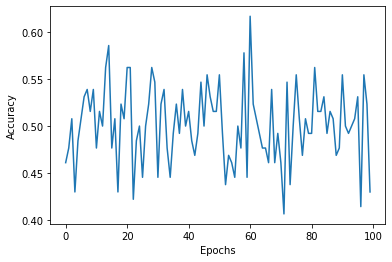

In [ ]:
plt.plot(history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')

np.max(history.history['val_accuracy'])

### Model 4: Using two inputs: 64 channels of the raw image blocks and labels from the first non-ML approach (intensity-based quantization)

This model was aimed at investigating if the labels from the first non-ML approach above (along with the raw images segmented into 64 channels -- each corresponding to a block) could be used to train the ML model to improve accuracy above what was obtained using just the first non-ML approach above. However, the validation accuracy did not improve significantly over what was obtained using just the non-ML model. In fact, the activation output from the first convolutional layer are zero, indicating that the images were not used for prediction.  The model relies only on the second label input and does nothing with the first image block input.

In [ ]:
class DataGen4(keras.utils.Sequence):
    
    def __init__(self, what='train', batch_size=16):
        self.what = what
        self.batch_size = batch_size
        
        self.all_files = [x for x in os.listdir(self.what) if x.endswith('jpg')]
        random.shuffle(self.all_files)
        
    def __len__(self):    
        return int(np.ceil(len(self.all_files) / self.batch_size))
        
    def __getitem__(self, batch_num):
        x = []
        x1 = []
        y = []
        x_final = []
        all_files = self.all_files
        batch_size = self.batch_size
        w = 6
        for file in all_files[batch_num * batch_size: (batch_num + 1) * batch_size]:
            image_id, _ = os.path.splitext(file)
            im_id = int(image_id)
            img, img_np, label, image_id = show_image(im_id, what=self.what)
            img = img.convert('L')
            
            img_quantize = blur_and_quantize(np.array(img))
            _, x_labels = vector_black_white_background_pieces(np.array(img_quantize), center_only=True)
            x1.append(x_labels)
            x2 = []
            
            img_block = blockshaped(np.array(img), 32, 32)
            for i in range(64):
                block = img_block[i]
                center = block[16-w:16+w, 16-w:16+w]
                x2.append(center)
            x2 = np.swapaxes(x2, 0, -1)
            x.append(np.array(x2) / 255.)
            
            dd = collections.Counter(x_labels)
            if dd[255.0] > dd[0.0]:
                x_final.append(1.0)
            else:
                x_final.append(0.0)
            
            y.append(0.0 if label == 'black' else 1.0)
        
        return (np.array(x), np.array(x1)), np.array(y)
        
    def on_epoch_end(self):
        random.shuffle(self.all_files)

In [ ]:
train_gen = DataGen4('train', batch_size=16)
val_gen = DataGen4('val', batch_size=16)

In [ ]:
train_gen[0][0][0].shape

(16, 12, 12, 64)

In [ ]:
def build_model4():
    img_inp = keras.Input(shape=(12, 12, 64), name='img')
    label_inp_1 = keras.Input(shape=(64,), name='raw_labels')
    
    x = keras.layers.Conv2D(8, (3, 3), activation='relu')(img_inp)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Flatten()(x)
    
    
    x = keras.layers.Concatenate()([x, label_inp_1])
    x = keras.layers.Dense(32, activation='relu')(x)
    out = keras.layers.Dense(1, activation='sigmoid')(x)
    
    
    model = keras.Model(inputs=[img_inp, label_inp_1], outputs=out)
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(1e-3),
        metrics=['accuracy'],
    )
    
    return model

In [ ]:
model = build_model4()
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 12, 12, 64)] 0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 10, 10, 8)    4616        img[0][0]                        
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 5, 5, 8)      0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
flatten_12 (Flatten)            (None, 200)          0           max_pooling2d_9[0][0]            
___________________________________________________________________________________________

In [ ]:
history = model.fit(train_gen, 
                    validation_data=val_gen, 
                    epochs=250,
                    verbose=0,
                    steps_per_epoch=8,
                    validation_freq=50)

0.984499990940094

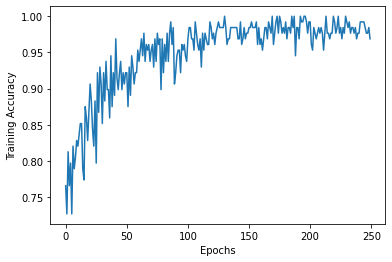

In [ ]:
plt.plot(history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')

np.max(history.history['val_accuracy'])

In [ ]:
model.layers[1].get_weights()[0].shape

(3, 3, 64, 8)

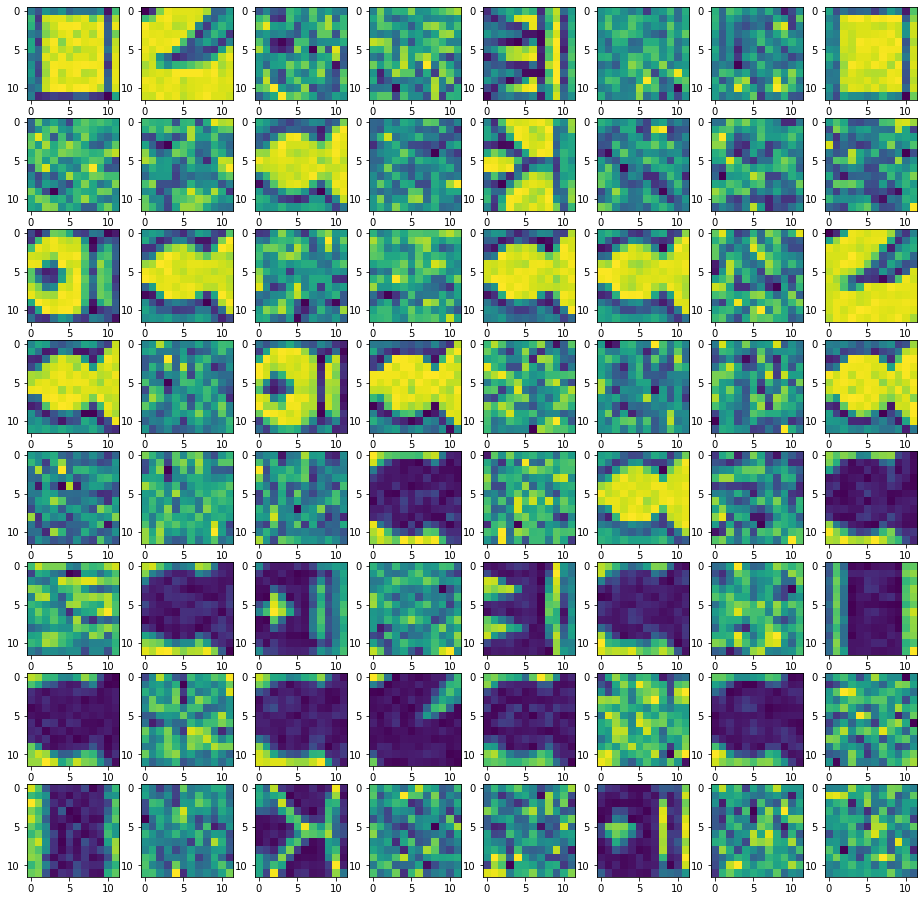

In [ ]:
new_model = keras.Model(inputs=model.input, outputs=model.layers[1].output)
debug_in = train_gen[0][0][0][1:2], train_gen[0][0][1][1:2]
output = np.squeeze(new_model.predict(debug_in))

debug_in = train_gen[0][0][0][1:2], train_gen[0][0][1][1:2]
output = np.squeeze(new_model.predict(debug_in))

fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(16, 16))
axes = axes.flatten()
for idx, ax in zip(range(debug_in[0].shape[-1]), axes):
    ax.imshow(np.squeeze(debug_in[0])[:, :, idx])

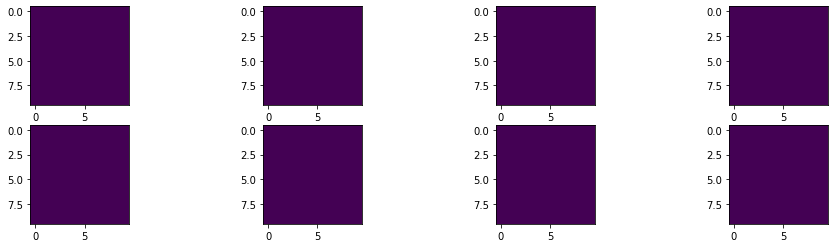

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 4))
axes = axes.flatten()
for idx, ax in zip(range(output.shape[-1]), axes):
    ax.imshow(output[:, :, idx])

### Model 5: Using 64 channels of the centers of blocks of the raw grayscale image as input

This approach did not work well in providing a training or validation accuracy above random guessing. 

In [ ]:
class DataGen5(keras.utils.Sequence):
    
    def __init__(self, what='train', batch_size=16):
        self.what = what
        self.batch_size = batch_size
        
        self.all_files = [x for x in os.listdir(self.what) if x.endswith('jpg')]
        random.shuffle(self.all_files)
        
    def __len__(self):    
        return int(np.ceil(len(self.all_files) / self.batch_size))
        
    def __getitem__(self, batch_num):
        x = []
        x1 = []
        y = []
        x_final = []
        all_files = self.all_files
        batch_size = self.batch_size
        w = 6
        for file in all_files[batch_num * batch_size: (batch_num + 1) * batch_size]:
            image_id, _ = os.path.splitext(file)
            im_id = int(image_id)
            img, img_np, label, image_id = show_image(im_id, what=self.what)
            img = img.convert('L')
            
            img_quantize = blur_and_quantize(np.array(img))
            _, x_labels = vector_black_white_background_pieces(np.array(img_quantize), center_only=True)
            x1.append(x_labels)
            x2 = []
            
            img_block = blockshaped(np.array(img), 32, 32)
            for i in range(64):
                block = img_block[i]
                center = block[16-w:16+w, 16-w:16+w]
                x2.append(center)
            x2 = np.swapaxes(x2, 0, -1)
            x.append(np.array(x2) / 255.)
            
            dd = collections.Counter(x_labels)
            if dd[255.0] > dd[0.0]:
                x_final.append(1.0)
            else:
                x_final.append(0.0)
            
            y.append(0.0 if label == 'black' else 1.0)
        
        return np.array(x), np.array(y)
        
    def on_epoch_end(self):
        random.shuffle(self.all_files)

In [ ]:
train_gen = DataGen5('train', batch_size=16)
val_gen = DataGen5('val', batch_size=16)

In [ ]:
def build_model5():
    img_inp = keras.Input(shape=(12, 12, 64), name='img')
    
    x = keras.layers.Conv2D(8, (3, 3), activation='relu')(img_inp)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Flatten()(x)

    x = keras.layers.Dense(32, activation='relu')(x)
    out = keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=img_inp, outputs=out)
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(1e-3),
        metrics=['accuracy'],
    )
    
    return model

In [ ]:
model = build_model5()
model.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 12, 12, 64)]      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 10, 10, 8)         4616      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 5, 5, 8)           0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 200)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                6432      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 11,081
Trainable params: 11,081
Non-trainable params: 0
______________________________________________________

In [ ]:
history = model.fit(train_gen, 
                    validation_data=val_gen, 
                    epochs=250,
                    verbose=0,
                    steps_per_epoch=8,
                    validation_freq=50)

0.5120000243186951

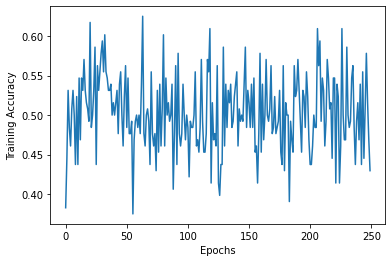

In [ ]:
plt.plot(history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')

np.max(history.history['val_accuracy'])